In [ ]:
from datasets import load_dataset

from transformers import Qwen2AudioForConditionalGeneration, AutoProcessor
import librosa
from datasets import load_dataset

# Load the Hugging Face dataset
# Assuming the dataset has an 'audio' column with audio files and a 'label' column with emotion labels

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
model = Qwen2AudioForConditionalGeneration.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct", device_map="auto")


# Replace 'your_dataset_name' with the name of your Hugging Face dataset
dataset = load_dataset("cairocode/IEMOCAP_WAV")

# Check the dataset structure



In [181]:
from datasets import load_dataset, concatenate_datasets

def filter_m_examples(example):
    return example["label"] != 4 and example["label"] != 5 #and example["speakerID"]==938
dataset  = dataset.filter(filter_m_examples)
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

combined_dataset = concatenate_datasets([train_dataset, validation_dataset, test_dataset])

Filter: 100%|██████████| 879/879 [00:00<00:00, 1985.80 examples/s]


In [183]:
ds  = combined_dataset.filter(filter_m_examples)
ds = ds.shuffle(seed=32)  # You can specify a seed for reproducibility

Filter: 100%|██████████| 4490/4490 [00:02<00:00, 2052.40 examples/s]


In [184]:
len(ds)

4490

In [185]:
import numpy as np
import soundfile as sf
from io import BytesIO
from transformers import AutoProcessor, Qwen2AudioForConditionalGeneration
import librosa
import warnings
warnings.filterwarnings("ignore", message="It is strongly recommended to pass the `sampling_rate` argument")
# Map emotions to numbers
emotion_mapping = {
    "Neutral": 0,
    "Happy": 1,
    "Sad": 2,
    "Angry": 3
}


# # Load processor and model
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
# model = Qwen2AudioForConditionalGeneration.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct", device_map="auto")
csv_file = "emotion_results_all.csv"
fieldnames = ["Transcript", "Label", "Predicted Emotion", "Mapped Value", "speaker_id"]
with open(csv_file, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()


# Example dataset
for i in range(len(ds)):
    transcript = ds['transcript'][i]
    actual_label = ds['label'][i]
    speaker_id = ds['speakerID'][i]
    conversations = [
        [{"role": "user", "content": [
            {"type": "audio", "array": ds['audio'][i]['array']},
            {"type": "text", "text": "Is this person happy, sad, angry or neutral?, answer in one word"}
        ]}],
    ]

    # Apply the chat template
    text = [processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False) for conversation in conversations]

    # Prepare audio inputs
    audios = []
    for conversation in conversations:
        for message in conversation:
            if isinstance(message["content"], list):
                for ele in message["content"]:
                    if ele["type"] == "audio":
                        # Convert numpy array to WAV and load with librosa
                        audio_data = ele["array"]
                        with BytesIO() as buffer:
                            sf.write(buffer, audio_data, samplerate=16000, format="WAV")  # Assuming 16kHz input
                            buffer.seek(0)
                            y, _ = librosa.load(buffer, sr=processor.feature_extractor.sampling_rate)
                            audios.append(y.astype(np.float32))

    # Prepare inputs
    inputs = processor(
        text=text,
        audios=audios,
        sampling_rate=16000,  # Explicitly set the sampling rate here
        return_tensors="pt",
        padding=True
    )

    # Fix attention_mask to avoid starting with 0 unless explicitly invalid
    inputs["attention_mask"][:, 0] = 1

    # Debugging: Inspect masks and tensor shapes
    special_audio_token_mask = (inputs["input_ids"] == model.config.audio_token_index)
    # print("special_audio_token_mask Shape:", special_audio_token_mask.shape)
    # print("special_audio_token_mask Sum:", special_audio_token_mask.sum().item())

    # Ensure special_audio_token_mask is valid
    if special_audio_token_mask.sum() == 0:
        # print("Warning: No special audio tokens found in input_ids.")
        # Add a placeholder token if required by the model
        audio_token_id = getattr(model.config, "audio_token_index", None)
        if audio_token_id is not None:
            inputs["input_ids"][:, 0] = audio_token_id  # Insert at the start of input_ids

    # Check for consistent batch sizes
    if inputs["input_ids"].shape[0] != inputs["feature_attention_mask"].shape[0]:
        batch_size_diff = inputs["feature_attention_mask"].shape[0] - inputs["input_ids"].shape[0]
        # print(f"Batch size mismatch: Adjusting with padding, batch_size_diff = {batch_size_diff}")
        
        # Padding input_ids and attention_mask to match feature_attention_mask batch size
        padding_shape = (batch_size_diff, inputs["input_ids"].shape[1])
        inputs["input_ids"] = torch.cat([inputs["input_ids"], torch.zeros(padding_shape, dtype=torch.long).to(inputs["input_ids"].device)], dim=0)
        inputs["attention_mask"] = torch.cat([inputs["attention_mask"], torch.zeros(padding_shape, dtype=torch.long).to(inputs["attention_mask"].device)], dim=0)

    # Move tensors to the correct device
    inputs["input_ids"] = inputs["input_ids"].to("cuda")
    inputs["input_features"] = inputs["input_features"].to("cuda")
    inputs["attention_mask"] = inputs["attention_mask"].to("cuda")
    inputs["feature_attention_mask"] = inputs["feature_attention_mask"].to("cuda")

    # Generate response
    try:
        generate_ids = model.generate(**inputs, max_length=256)
        generate_ids = generate_ids[:, inputs.input_ids.size(1):]

        # Decode the response
        response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
        # print("Response:", response)
    except RuntimeError as e:
        print("RuntimeError during generation:", str(e))
        print("Debugging info:")
        print(f"Input IDs Shape: {inputs['input_ids'].shape}")
        print(f"Feature Attention Mask Shape: {inputs['feature_attention_mask'].shape}")
        print(f"Input Features Shape: {inputs['input_features'].shape}")
        print(f"Attention Mask Shape: {inputs['attention_mask'].shape}")

    predicted_emotion = response[0].strip().capitalize()
    mapped_value = emotion_mapping.get(predicted_emotion, -1)

    # Print the result in a single line
    print(f" | Actual Label: {actual_label} | Predicted Emotion: {mapped_value} | Transcript: {transcript}")

    # Save results to CSV
    with open(csv_file, mode="a", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writerow({
            "Transcript": transcript,
            "Label": actual_label,
            "Predicted Emotion": predicted_emotion,
            "Mapped Value": mapped_value, 
            "speaker_id": speaker_id
        })
    del inputs
    # del input_features
    torch.cuda.empty_cache()  # Optional: Clears the GPU cache


 | Actual Label: 2 | Predicted Emotion: 2 | Transcript: I know it's really crappy timing, but I don't have a choice.
 | Actual Label: 3 | Predicted Emotion: 3 | Transcript: Like I know I paid last month, but it hasn't been paid and you charged me a late fee.
 | Actual Label: 2 | Predicted Emotion: 2 | Transcript: And I, you know, I mean, I said I was sorry and I brought it back to her kind of and I like put it on the ground and she was like, no, it's fine.  She was like, I would rather have her back, honestly.
 | Actual Label: 1 | Predicted Emotion: 0 | Transcript: I don't know.  I think this is a pretty good spot.  I mean, look at the view of the moon from here.
 | Actual Label: 0 | Predicted Emotion: 0 | Transcript: Well, maybe he just wanted to see her again.
 | Actual Label: 0 | Predicted Emotion: 0 | Transcript: No, don't think like that.
 | Actual Label: 2 | Predicted Emotion: 2 | Transcript: Well, I lost them.
 | Actual Label: 3 | Predicted Emotion: 3 | Transcript: Very good ide

Accuracy: 0.6751
UAR (Unweighted Average Recall): 0.5789
F1-Score: 0.6463


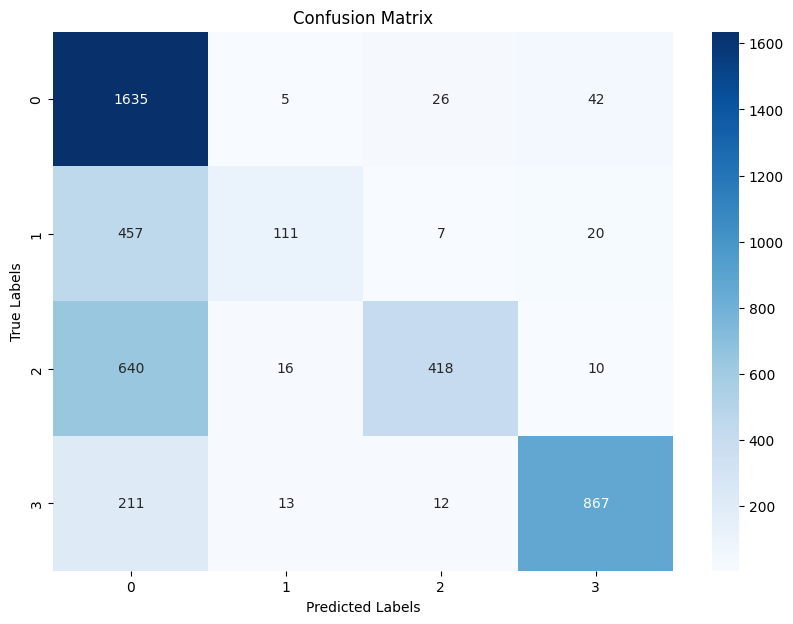

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix

csv_path = r"C:\Users\Paolo\Documents\carol_emo_rec\MLLM\idk\emotion_results_all.csv"  # Replace with your CSV file path
data = pd.read_csv(csv_path)

# Extract "Label" and "Mapped Value" columns
true_labels = data["Label"].astype(int)
predicted_labels = data["Mapped Value"].astype(int)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Use 'macro' for unweighted F1
uar = recall_score(true_labels, predicted_labels, average='macro')  # Macro-average Recall is UAR

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"UAR (Unweighted Average Recall): {uar:.4f}")
print(f"F1-Score: {f1:.4f}")

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
